In [1]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import re
from datetime import timedelta
import dateutil
import numpy as np
import matplotlib.dates as mdates

In [2]:
%matplotlib inline

In [3]:
project_dir = '..'
%cd ..

/gpfs/gsfs10/users/DSST/ls_logging


### Scripts used:

The first script is run as a crontab and calls the second script on felix and on a compute node

In [4]:
!cat scripts/run_ls_testing_script_array.sh

#!/bin/bash
bash /data/DSST/ls_logging/scripts/ls_test.sh
# can add ibfdr nodes if there is a way to detect which network interface is
# being used. should be easy. I encountered a silly bug
# /usr/local/slurm/bin/sbatch /data/DSST/ls_logging/scripts/ls_test.sh --constraint=ibfdr
/usr/local/slurm/bin/sbatch /data/DSST/ls_logging/scripts/ls_test.sh --constraint=10g

In [5]:
!cat scripts/ls_test.sh

#!/bin/bash
HOST_ID=$(hostname -s)
BASE_DIR=/data/DSST/ls_logging
# the following line is not working properly
NODE_TYPE=$(if [  $(/sbin/ip neigh |head -n1|grep -iq ib0) ];then echo "ibfdr_nodes/";else echo "other_nodes/";fi)
LOGFILE=${BASE_DIR}/${NODE_TYPE}ls_logs_${HOST_ID}.txt

# This is a list of different shares that captures a number of partitions
DIRLIST=(/data/CMI_preproc /data/DSST /data/DSST_dua /data/Dnude /data/FMRIF /data/HCP /data/Hbnssi /data/Hippo_ETPB /data/Hippo_hr /data/Histed_imaging /data/MLDSST /data/MLcore /data/NDAR /data/NIMH_MHSNIR /data/NIMH_PROTOCOL /data/NIMH_SFIM /data/NNDSP /data/SFIM /data/Xscanner /data/finnes /data/handwerkerd /data/jangrawdc /data/javiergc $HOME)

TIME=$(date --rfc-3339=seconds | sed 's/ /T/')

# Capture squeue information to assess whether particular users correlate with
# slow access times
/usr/local/slurm/bin/squeue  > ${BASE_DIR}/squeue_logs/${HOST_ID}_${TIME}_squeue.txt

# Write the time of this run into the logfile
echo Date run

### Functions used

In [6]:
def format_log_seconds(x):
    if x == '':
        return ''
    
    try:
        x = int(float(x))
    except ValueError:
        x = -1 * int(float(x[1:]))
    if x >= -3:
        out =  '1' + '0'*(x+3) + 'ms'
    elif x >= -6:
        out =  '1' + '0'*(x+6) + 'us'
    elif x >= -9:
        out =  '1' + '0'*(x+9) + 'ns'
    return out

def parse_time(time_str):
    regex = re.compile(r'((?P<hours>\d+?)h)?((?P<minutes>\d+?)m)?((?P<seconds>[0-9\.]+?)s)?')
    parts = regex.match(time_str)
    if not parts:
        return
    parts = parts.groupdict()
    time_params = {}
    for (name, param) in parts.items():
        if param:
            time_params[name] = float(param)
    return timedelta(**time_params)

def parse_log(log_path):
    node_name = log_path.name.split('_')[-1].split('.')[0]
    node_class = log_path.parent.name.split('_')[0]
    log_text = log_path.read_text()
    dfs=[]
#     import pdb;pdb.set_trace()
    for logi in log_text.split('\nDate run'):
        logi = logi.splitlines()
        if len(logi) > 3:
#             try:
            df_sub  = parse_run(logi)
#             except ValueError:
#                 continue
        else:
            continue
        try:
            dfs.append(df_sub)
        except ValueError:
            continue
    res = pd.concat(dfs,axis=0)
    res['node_name'] = node_name
    res['node_class'] = node_class
    return res
        
        
def parse_run(logi):
#     logi = logi.splitlines()
    dr = dateutil.parser.parse(logi.pop(0).split(': ')[-1])
    res_df = pd.DataFrame(dict(dirs = logi[0::6],
        num_items = [int(ni) for ni in logi[1::6]],
        real_time = [parse_time(tt.split('\t')[-1]) for tt in logi[3::6]],
        user_time = [parse_time(tt.split('\t')[-1]) for tt in logi[4::6]],
        sys_time = [parse_time(tt.split('\t')[-1]) for tt in logi[5::6]]))
    res_df['date_run'] = dr
    return res_df

def parse_all_logs(log_path_list):
    dfs = []
    for f in log_path_list:
        try:
            df_sub = parse_log(f)
            dfs.append(df_sub)
        except:
            continue
    return pd.concat(dfs,axis=0)

def dir_to_partition(dir_in):
    
    part_mapping = {
    "/data/CMI_preproc": "gs10",
    "/data/DSST": "gs10",
    "/data/DSST_dua": "gs10",
    "/data/Dnude": "gs4",
    "/data/FMRIF": "spin1",
    "/data/HCP": "gs6",
    "/data/Hbnssi": "gs7",
    "/data/Hippo_ETPB": "gs11",
    "/data/Hippo_hr": "gs6",
    "/data/Histed_imaging": "gs9",
    "/data/MLDSST": "gs10",
    "/data/MLcore": "gs8",
    "/data/NDAR": "gs7",
    "/data/NIMH_MHSNIR": "gs4",
    "/data/NIMH_PROTOCOL": "gs4",
    "/data/NIMH_SFIM": "gs4",
    "/data/NNDSP": "gs6",
    "/data/SFIM": "spin1",
    "/data/Xscanner": "gs5",
    "/data/finnes": "gs6",
    "/data/handwerkerd": "spin1",
    "/data/jangrawdc": "gs8",
    "/data/javiergc": "spin1",
    "/home/rodgersleejg": "home"}
    
    vals = dir_in.split('/')
    if len(vals) >2:
        possible_partition = dir_in.split('/')[1]
    else: 
        # readlink ~ resolves to empy string
        possible_partition = "home"

    return part_mapping.get(dir_in,possible_partition)

### Assessing logs for felix

The following is an example of using the logs to assess activity on felix

In [7]:
df_logs = parse_log(Path('other_nodes/ls_logs_felix.txt'))
len(df_logs)

4464

In [8]:
time_cols = ["real_time"]
df_plot = (df_logs
           .melt(
               id_vars=df_logs.columns.drop(time_cols),
               value_vars=time_cols,
               value_name="duration",
               var_name="time_measure")
           .assign(duration = lambda df: df.duration.apply(lambda x:x.total_seconds()),
                   partition = lambda df: df.dirs.apply(lambda x:dir_to_partition(x)))
           .assign(time_per_item = lambda df: np.log10(df.duration / df.num_items),
                   date_time = lambda df: df.date_run.dt.strftime('%Y-%m-%d %H:%M'))
          )
# remove rows where time is inf:
df_plot = df_plot.loc[np.isfinite(df_plot.time_per_item),:]
df_plot.head()

,dirs,num_items,user_time,sys_time,date_run,node_name,node_class,time_measure,duration,partition,time_per_item,date_time
0,/data/CMI_preproc,797,00:00:01.243000,00:00:00.510000,2018-10-18 15:32:01-04:00,felix,other,real_time,2.397,gs10,-2.521790,2018-10-18 15:32
1,/data/DSST,8160,00:00:00.056000,00:00:00.113000,2018-10-18 15:32:01-04:00,felix,other,real_time,0.241,gs10,-4.529673,2018-10-18 15:32
2,/data/DSST_dua,1379,00:00:00.010000,00:00:00.009000,2018-10-18 15:32:01-04:00,felix,other,real_time,0.025,gs10,-4.741624,2018-10-18 15:32
3,/data/Dnude,21911,00:00:00.692000,00:00:00.359000,2018-10-18 15:32:01-04:00,felix,other,real_time,1.211,gs4,-4.257518,2018-10-18 15:32
4,/data/FMRIF,612,00:00:00.007000,00:00:00.037000,2018-10-18 15:32:01-04:00,felix,other,real_time,0.172,spin1,-3.551223,2018-10-18 15:32


## Plot a row for each partition 
### (using the max when more then one value is available)
X is time, Y is how long the command took.

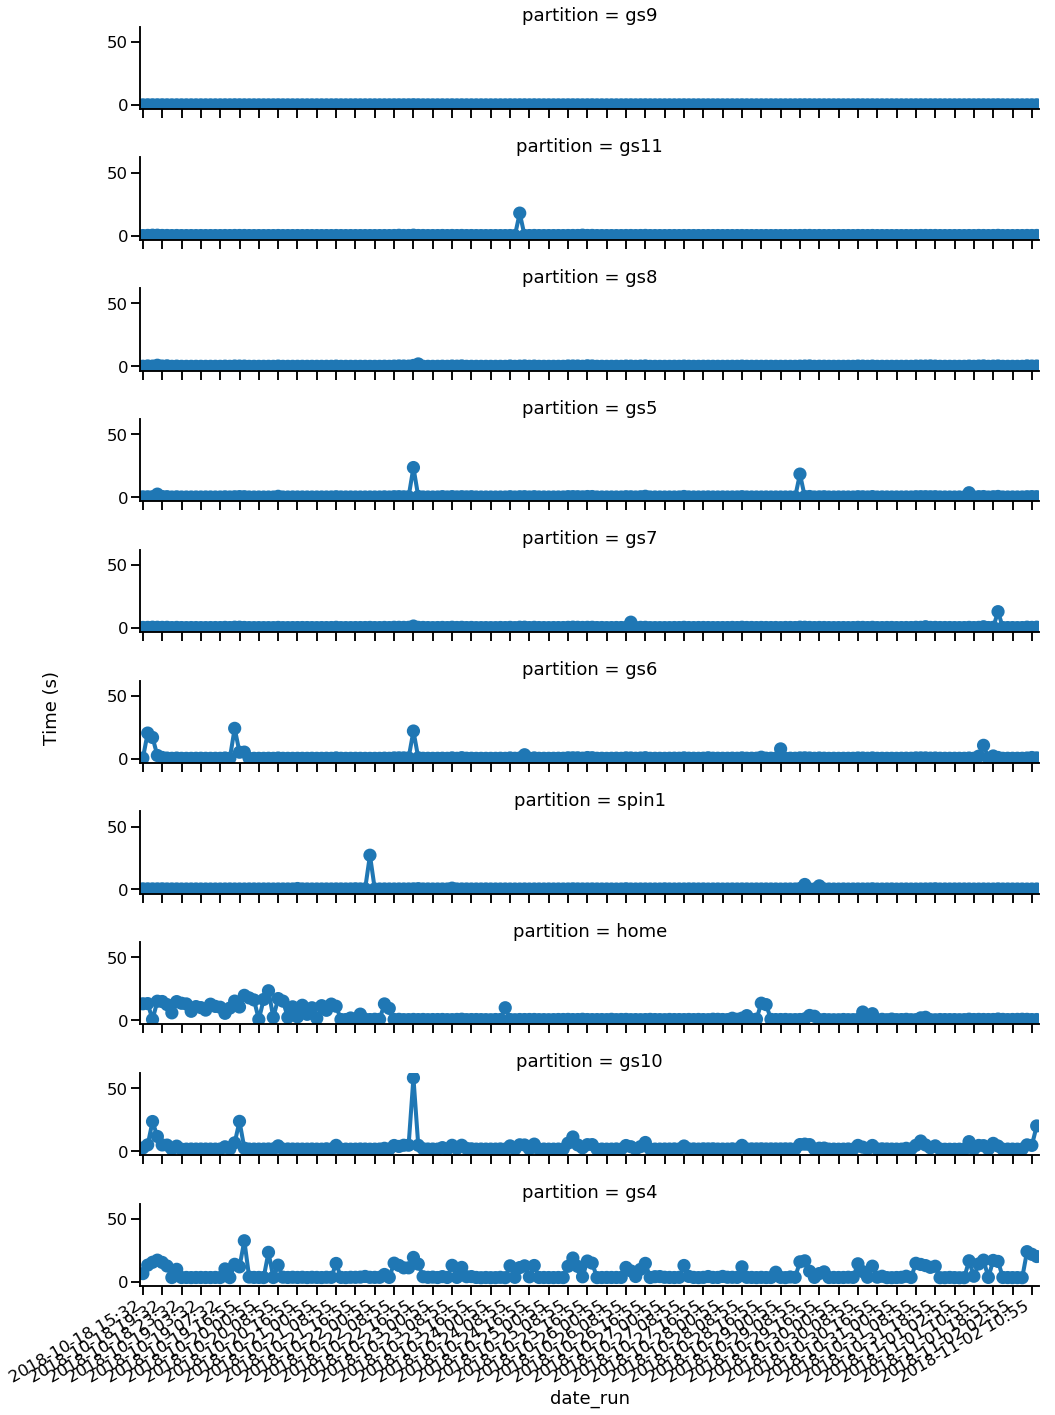

In [12]:
sns.set_context(context='talk', font_scale=1)

df_plot_with_max = df_plot.groupby(['partition','date_run'])['duration'].agg(max).sort_values().reset_index()

ax = sns.catplot(data=df_plot_with_max, kind='point', row='partition', x='date_run',y='duration',aspect=3)
ax.fig.autofmt_xdate()
bottom_ax = ax.axes[-1][0]
orig_ticks = bottom_ax.get_xticks()
orig_tick_labels = bottom_ax.get_xticklabels()
bottom_ax.set_xticks(range(0,len(orig_ticks),4))
bottom_ax.set_xticklabels(dateutil.parser.parse(ot.get_text()).strftime('%Y-%m-%d %H:%M') for ot in orig_tick_labels[0::4])

for axrow in ax.axes:
    for axi in axrow:
        axi.set_ylabel('')

ax.fig.text(0.06, 0.5, 'Time (s)', ha='center', va='center', rotation='vertical')
# ax.set_yticklabels([format_log_seconds(yt.get_text()) for yt in bottom_ax.get_yticklabels()])

ax.fig.set_figheight(20)
ax.fig.tight_layout()

## Normalized by number of files

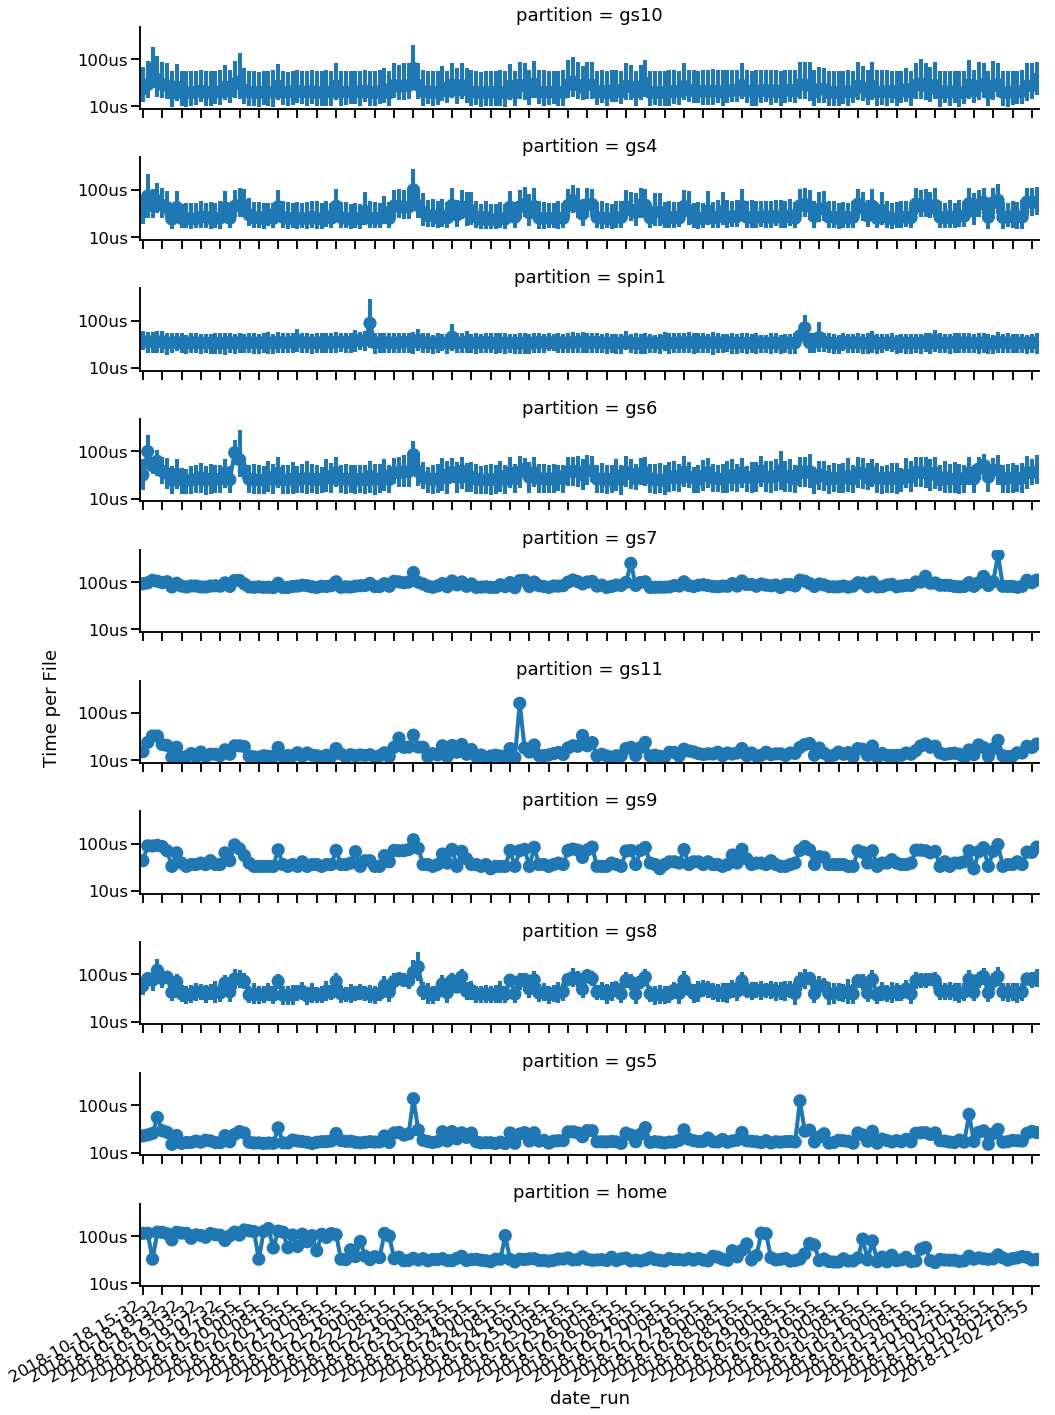

In [13]:
sns.set_context(context='talk', font_scale=1)


ax = sns.catplot(data=df_plot, kind='point', row='partition', x='date_run',y='time_per_item',aspect=3)
ax.fig.autofmt_xdate()
bottom_ax = ax.axes[-1][0]
orig_ticks = bottom_ax.get_xticks()
orig_tick_labels = bottom_ax.get_xticklabels()
bottom_ax.set_xticks(range(0,len(orig_ticks),4))
bottom_ax.set_xticklabels(dateutil.parser.parse(ot.get_text()).strftime('%Y-%m-%d %H:%M') for ot in orig_tick_labels[0::4])

for axrow in ax.axes:
    for axi in axrow:
        axi.set_ylabel('')

ax.fig.text(0.06, 0.5, 'Time per File', ha='center', va='center', rotation='vertical')
ax.set_yticklabels([format_log_seconds(yt.get_text()) for yt in bottom_ax.get_yticklabels()])

ax.fig.set_figheight(20)
ax.fig.tight_layout()


In [18]:
df_plot.to_csv('current_log_extracted.csv',index=False)
len(df_plot)


4278